# Classical Uniform Electron Beam Simulation

This notebook simulates the trajectory of electrons in a time-varying magnetic field and visualizes the pattern formed on a screen. It is based on the `classical-uniform.py` script.

## 1. Imports

Import necessary libraries: `numpy` for numerical operations, `scipy` for solving ordinary differential equations, and `matplotlib` for plotting.

In [39]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## 2. Physical Constants and Simulation Parameters

Define the physical constants (in Gaussian units) and the parameters for the simulation.

In [40]:
# Physical constants (Gaussian units)
m_e = 9.10938356e-28  # Mass of electron (g)
e_charge = 4.80320425e-10 # Charge of electron (statcoulomb or esu)
c_light = 2.99792458e10   # Speed of light (cm/s)

# Simulation parameters
# CRITICAL FIX: Reduced B-field strength to prevent non-physical velocities.
# The original value of 10.0 G caused numerical instability.
B_02_sim = 0.1   # Gauss
B_03_sim = 0.05   # Gauss
w_2_sim = 2.0e7    # rad/s
w_3_sim = 2.1e7    # rad/s
L_sim = 100.0      # cm (length of the beam path to the screen)
v_initial_sim = c_light / 10.0 # Initial velocity in x1 direction

num_electrons_sim = 1000 # Number of electrons to simulate

## 3. B-Field Definitions

Functions to define the time-varying magnetic fields $B_2(t)$ and $B_3(t)$ and their time derivatives.

In [41]:
def B2_field(t, B_02_param, w_2_param):
    return B_02_param * np.sin(w_2_param * t)

def dB2_dt_field(t, B_02_param, w_2_param):
    return B_02_param * w_2_param * np.cos(w_2_param * t)

def B3_field(t, B_03_param, w_3_param):
    return B_03_param * np.sin(w_3_param * t)

def dB3_dt_field(t, B_03_param, w_3_param):
    return B_03_param * w_3_param * np.cos(w_3_param * t)

## 4. Equations of Motion

Defines the system of ordinary differential equations (ODEs) that describe the motion of an electron in the magnetic fields.

The ODE function takes `t_offset` as an argument. This offset represents the launch time of a specific electron on a global clock, allowing us to simulate electrons launched at different phases of the oscillating B-fields.

In [42]:
# REFACTORED: The ODE function is now defined once and takes t_offset as an argument.
# This is a cleaner and more robust approach than redefining a function in each loop iteration.
def equations_of_motion(t_particle, y, m, e, c, B_02_param, w_2_param, B_03_param, w_3_param, t_offset):
    # The B-field evolves on a global clock. Its phase depends on when the electron was launched (t_offset).
    # The solver's time, t_particle, is the time since that specific electron's launch.
    global_t = t_particle + t_offset

    x1, x2, x3, v1, v2, v3 = y

    B2_t = B2_field(global_t, B_02_param, w_2_param)
    dB2_dt_t = dB2_dt_field(global_t, B_02_param, w_2_param)
    B3_t = B3_field(global_t, B_03_param, w_3_param)
    dB3_dt_t = dB3_dt_field(global_t, B_03_param, w_3_param)

    # The equations of motion as provided in the notebook
    a1 = (e / (2 * m * c)) * (x3 * dB2_dt_t - x2 * dB3_dt_t)
    a2 = (e / (m * c)) * (0.5 * x1 * dB3_dt_t - v1 * B3_t)
    a3 = (e / (m * c)) * (-0.5 * x1 * dB2_dt_t + v1 * B2_t)

    return [v1, v2, v3, a1, a2, a3]

## 5. Simulate Electron Trajectories

This section simulates the trajectories of multiple electrons. Each electron is launched at a slightly different time (`t_offset`) to capture the effect of the oscillating fields. The final positions of the electrons on a screen located at $x_1 = L$ are recorded.

In [43]:
screen_positions_x2 = []
screen_positions_x3 = []

# Approximate time of flight for one electron. Used to set the integration interval.
t_flight_approx = L_sim / v_initial_sim
t_span = (0, t_flight_approx)

# REVISED LOGIC/COMMENT: The following clarifies how electrons are launched.
# To generate a pattern, we simulate electrons launched at different times into the
# oscillating magnetic fields. This is modeled with a 't_offset' for each electron,
# representing its launch time on a global clock. This is equivalent to applying
# a different initial phase of the B-fields for each electron.
characteristic_period = 2 * np.pi / max(w_2_sim, w_3_sim)
total_launch_time = characteristic_period * 5 # Launch electrons over 5 cycles of the faster B-field

print(f"Approximate time of flight: {t_flight_approx:.2e} s")
print(f"Simulating {num_electrons_sim} electrons...")

for i in range(num_electrons_sim):
    # This offset simulates launching electrons sequentially into the evolving B-fields.
    t_offset = (i / num_electrons_sim) * total_launch_time

    # Initial conditions: [x1, x2, x3, v1, v2, v3]
    y0 = [0, 0, 0, v_initial_sim, 0, 0]

    # Set evaluation times for dense output. Ensures smooth trajectory data.
    num_time_points = int(max(w_2_sim, w_3_sim) * t_flight_approx / (2*np.pi) * 30)
    num_time_points = max(num_time_points, 200)
    t_eval = np.linspace(t_span[0], t_span[1], num_time_points)

    # REFACTORED: Use the 'args' parameter to pass arguments to the ODE function.
    # This is the standard, efficient, and correct way to handle changing parameters in a loop.
    sol = solve_ivp(
        fun=equations_of_motion,
        t_span=t_span,
        y0=y0,
        method='RK45',
        dense_output=True, # Recommended for accurate final point interpolation
        t_eval=t_eval,
        args=(m_e, e_charge, c_light, B_02_sim, w_2_sim, B_03_sim, w_3_sim, t_offset)
    )

    # Extract the final position on the screen
    final_state = sol.y[:, -1]
    screen_positions_x2.append(final_state[1])
    screen_positions_x3.append(final_state[2])

    if (i+1) % (num_electrons_sim // 10) == 0:
        print(f"  Simulated {i+1}/{num_electrons_sim} electrons...")

print("Simulation complete.")

Approximate time of flight: 3.34e-08 s
Simulating 1000 electrons...
  Simulated 100/1000 electrons...
  Simulated 200/1000 electrons...
  Simulated 300/1000 electrons...
  Simulated 400/1000 electrons...
  Simulated 500/1000 electrons...
  Simulated 600/1000 electrons...
  Simulated 700/1000 electrons...
  Simulated 800/1000 electrons...
  Simulated 900/1000 electrons...
  Simulated 1000/1000 electrons...
Simulation complete.


## 6. Plot the Screen Pattern

Visualize the positions of the electrons on the screen. This creates a scatter plot of $(x_2, x_3)$ coordinates.

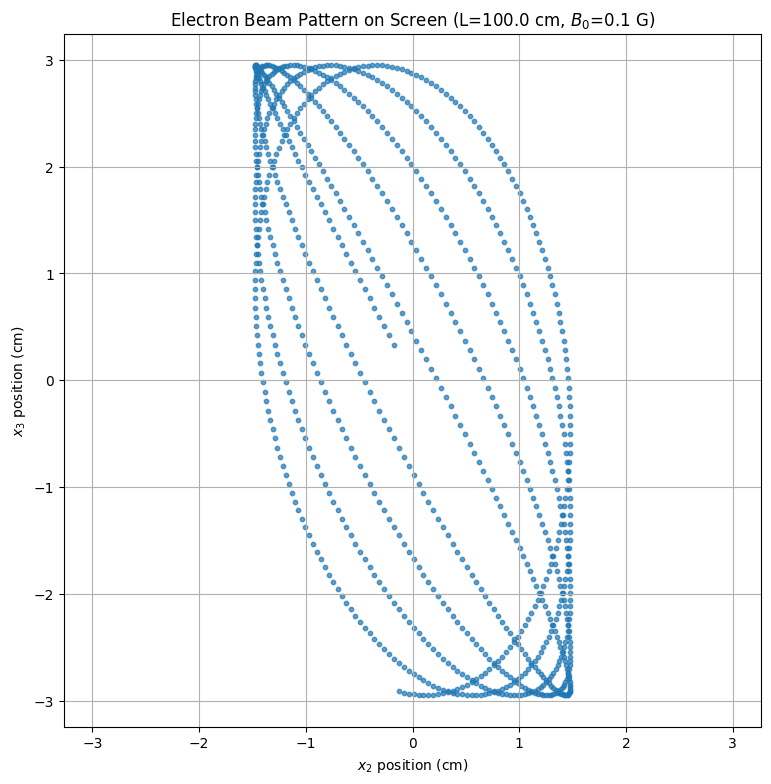

In [44]:
plt.figure(figsize=(9, 9))
plt.scatter(screen_positions_x2, screen_positions_x3, s=10, alpha=0.7)
plt.title(f'Electron Beam Pattern on Screen (L={L_sim} cm, $B_0$={B_02_sim} G)')
plt.xlabel('$x_2$ position (cm)')
plt.ylabel('$x_3$ position (cm)')
plt.grid(True)
plt.axis('equal')
plt.show()